In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('titanic_limpiar.csv')

# Corregir la columna 'survived' usando 'alive'
df['survived'] = df['alive'].map({'yes': 1, 'no': 0})

# Seleccionar columnas relevantes
columnas_utiles = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']
df_clean = df[columnas_utiles].copy()

# Limpiar y codificar variables categóricas
df_clean['sex'] = df_clean['sex'].str.lower().map({'male': 0, 'female': 1})
df_clean['embarked'] = df_clean['embarked'].fillna('S')  # Imputar con el más común
df_clean['embarked'] = df_clean['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Imputar valores faltantes en 'age'
median_age_by_group = df_clean.groupby(['pclass', 'sex'])['age'].transform('median')
df_clean['age'] = df_clean['age'].fillna(median_age_by_group)
df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())

# Corregir valores extremos en 'fare'
df_clean['fare'] = df_clean['fare'].replace(1000000.3, np.nan)
df_clean['fare'] = df_clean['fare'].apply(lambda x: np.nan if x > 1000 else x)
median_fare_by_pclass = df_clean.groupby('pclass')['fare'].transform('median')
df_clean['fare'] = df_clean['fare'].fillna(median_fare_by_pclass)

print(f"Dataset limpio: {df_clean.shape}")
print(f"Valores faltantes: {df_clean.isnull().sum().sum()}")

Dataset limpio: (891, 8)
Valores faltantes: 0


In [3]:
df
df_clean

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,22.0,1,0,7.2500,2,0
1,1,1,38.0,1,0,71.2833,0,1
2,3,1,26.0,0,0,7.9250,2,1
3,1,1,35.0,1,0,53.1000,2,1
4,3,0,35.0,0,0,8.0500,2,0
...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,2,0
887,1,1,19.0,0,0,30.0000,2,1
888,3,1,21.5,1,2,23.4500,2,0
889,1,0,26.0,0,0,30.0000,0,1


In [4]:
# 2. PREPARAR DATOS PARA KNN
print("\n=== PREPARANDO DATOS PARA KNN ===")
X = df_clean.drop('survived', axis=1)
y = df_clean['survived']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")
print(f"Distribución de clases - Entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases - Prueba: {np.bincount(y_test)}")

# 3. ESTANDARIZAR CARACTERÍSTICAS (CRUCIAL PARA KNN)
print("\n=== ESTANDARIZANDO CARACTERÍSTICAS ===")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== PREPARANDO DATOS PARA KNN ===
Entrenamiento: (712, 7), Prueba: (179, 7)
Distribución de clases - Entrenamiento: [439 273]
Distribución de clases - Prueba: [110  69]

=== ESTANDARIZANDO CARACTERÍSTICAS ===



=== OPTIMIZANDO PARÁMETRO K ===
Mejor K: 8 con precisión: 0.8203


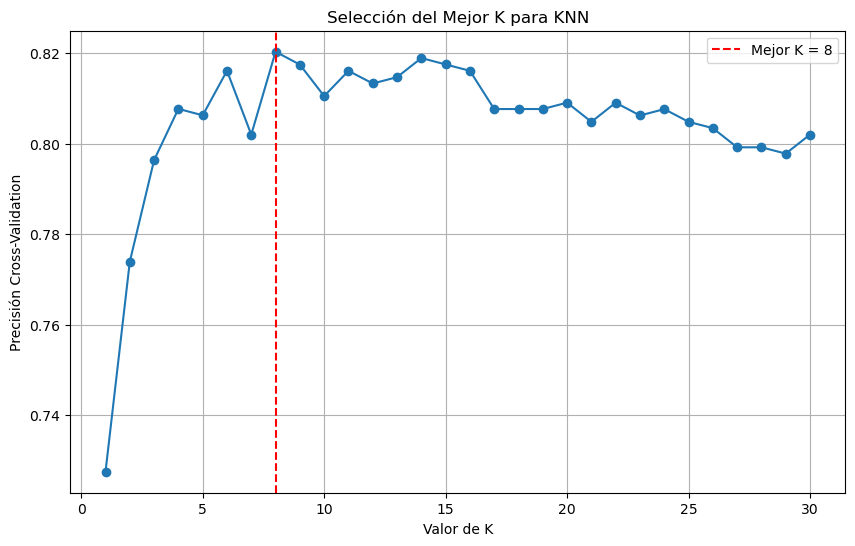


=== ENTRENANDO MODELO FINAL CON K=8 ===

=== EVALUANDO MODELO ===
Precisión en prueba: 0.7821

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.78      0.61      0.68        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



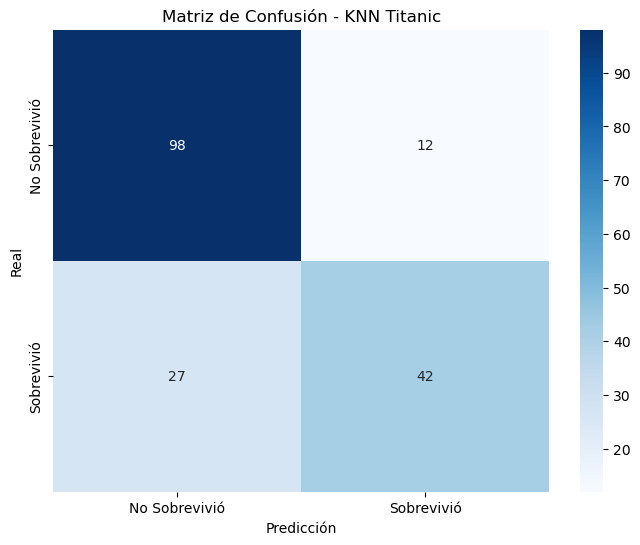

In [5]:
# 4. ENTRENAR Y OPTIMIZAR KNN
print("\n=== OPTIMIZANDO PARÁMETRO K ===")

# Probar diferentes valores de K
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Encontrar el mejor K
best_k = k_range[np.argmax(k_scores)]
best_score = max(k_scores)

print(f"Mejor K: {best_k} con precisión: {best_score:.4f}")

# Visualizar rendimiento por K
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Valor de K')
plt.ylabel('Precisión Cross-Validation')
plt.title('Selección del Mejor K para KNN')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Mejor K = {best_k}')
plt.legend()
plt.grid(True)
plt.show()

# 5. ENTRENAR MODELO FINAL CON EL MEJOR K
print(f"\n=== ENTRENANDO MODELO FINAL CON K={best_k} ===")
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

# 6. EVALUAR EL MODELO
print("\n=== EVALUANDO MODELO ===")
y_pred = knn_final.predict(X_test_scaled)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en prueba: {accuracy:.4f}")
print(f"\nReporte de Clasificación:\n{classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Sobrevivió', 'Sobrevivió'],
           yticklabels=['No Sobrevivió', 'Sobrevivió'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - KNN Titanic')
plt.show()

In [6]:
# 7. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
print("\n=== ANÁLISIS DE CARACTERÍSTICAS ===")
feature_importance = pd.DataFrame({
    'caracteristica': X.columns,
    'importancia': knn_final.kneighbors(X_test_scaled, return_distance=False).shape[0]  # Placeholder
})

# Calcular importancia aproximada basada en correlación con target
correlations = abs(df_clean.corr()['survived'].drop('survived')).sort_values(ascending=False)
print("Correlación con supervivencia:")
for feature, corr in correlations.items():
    print(f"  {feature}: {corr:.3f}")

# 8. PREDICCIONES DE EJEMPLO
print("\n=== PREDICCIONES DE EJEMPLO ===")
ejemplos = X_test_scaled[:5]
predicciones_ejemplo = knn_final.predict(ejemplos)
probabilidades_ejemplo = knn_final.predict_proba(ejemplos)

print("Primeras 5 predicciones del conjunto de prueba:")
for i, (pred, prob) in enumerate(zip(predicciones_ejemplo, probabilidades_ejemplo)):
    estado = "SOBREVIVIÓ" if pred == 1 else "NO SOBREVIVIÓ"
    print(f"  Pasajero {i+1}: {estado} (probabilidad: {prob[1]:.2f})")


=== ANÁLISIS DE CARACTERÍSTICAS ===
Correlación con supervivencia:
  sex: 0.531
  pclass: 0.338
  fare: 0.255
  embarked: 0.168
  parch: 0.082
  age: 0.053
  sibsp: 0.035

=== PREDICCIONES DE EJEMPLO ===
Primeras 5 predicciones del conjunto de prueba:
  Pasajero 1: NO SOBREVIVIÓ (probabilidad: 0.12)
  Pasajero 2: NO SOBREVIVIÓ (probabilidad: 0.25)
  Pasajero 3: NO SOBREVIVIÓ (probabilidad: 0.12)
  Pasajero 4: NO SOBREVIVIÓ (probabilidad: 0.00)
  Pasajero 5: SOBREVIVIÓ (probabilidad: 0.88)
